In [1]:
from classy import Class
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d 
from scipy.integrate import solve_ivp
import numpy as np
import work_in_class.wicmath as wicm
from work_in_class import cosmo_extra
import analyze_coeffs as ac

In [2]:
obs_labels = ['H', 'D_A', 'f']

In [3]:
def reldev(exact, approx):
    return (exact - approx) / np.max([np.abs(exact), np.abs(approx)], axis=0)

In [4]:
zlim = 1000
def get_cosmology(params):
    cosmo = Class()
    cosmo.set(params)
    cosmo.compute()
    b = cosmo.get_background()

    ######
    zTMP = b['z']
    z = zTMP[zTMP<zlim]
    lna = np.log(1+z)
    logX = np.log(b['(.)rho_smg'][zTMP<zlim]/b['(.)rho_smg'][-1])
    return cosmo, b, z, lna, logX

In [5]:
def compute_observables_fit(lna, z, logX, b):
    Xw, ThreewPlus1 = wicm.diff(lna, logX)
    w = ThreewPlus1/3. - 1

    rhoDE = np.exp(logX) * b['(.)rho_smg'][-1]
    rhoM = (b['(.)rho_b'] + b['(.)rho_cdm'])[b['z'] < zlim]
    rhoR = (b['(.)rho_g'] + b['(.)rho_ur'])[b['z'] < zlim]

    return ac._compute_H_DA_f_from_array([[lna, z, Xw], [rhoM, rhoR, rhoDE, w]])

In [6]:
def compute_observables_th(cosmo, b):
    H = b['H [1/Mpc]'][b['z'] < zlim]   # zlim MUST be equal to z_max_pk
    DA = b['ang.diam.dist.'][b['z'] < zlim]
    w = b['w_smg'] # [b['z'] < zlim]

    rhoM = (b['(.)rho_b'] + b['(.)rho_cdm'])


    OmegaDEwF_exact = interp1d(z, (b['(.)rho_smg']/b['(.)rho_crit']*w)[b['z'] <= zlim])
    OmegaMF = interp1d(z, (rhoM/b['(.)rho_crit'])[b['z'] <= zlim])

    time_boundaries = [z[0], z[-1]]
    f = solve_ivp(cosmo_extra.fprime(OmegaDEwF_exact, OmegaMF), time_boundaries, [1],
                  method='LSODA', dense_output=True).sol(b['z'][b['z'] <= zlim])[0]
                  
                 #  [cosmo_extra.growthrate_at_z(cosmo, zlim)], ---> [1] as in analyze_coeffs.
    
    return H, DA, f

In [7]:
def fit(fitting_function, basis, i, lna, logX, z, b):
    popt, yfit = wicm.fit(fitting_function, basis, logX, i)
    H, DA, f = compute_observables_fit(lna, z, logX, b)
    return popt, yfit, [H, DA, f]

# Different basis

## Fitting functions

In [8]:
def Taylor_fraction_legacy_c0(x, c):
    s = 0
    for i, ci in enumerate(c):
        s += ci * x**(i/3.)
    return s

def Taylor_fraction_n_legacy_c0(x, c):
    s = 0
    for i, ci in enumerate(c):
        s += ci * x**(1./(i+1))
    return s

def Taylor_fraction_n_combined_legacy_c0(x, c):
    s = 0
    for i, ci in enumerate(c[:len(c)]):
        s += ci * x**(1./(i+1))
    for i, ci in enumerate(c[len(c):]):
        s += ci * x**(i+1)
    return s

## Plots

In [9]:
z = np.linspace(0, 1e3, 10000)
lna = np.log(1+z)

### $\log(1+z)^n$

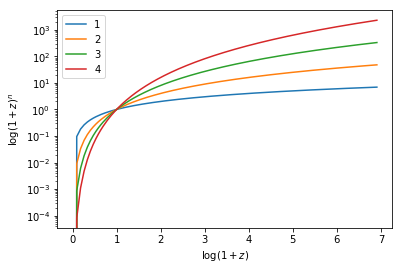

In [10]:
f, ax = plt.subplots(1,1)
for n in range(1, 5):
    ax.plot(lna, lna**(n), label=n)
ax.set_xlabel(r'$\log(1+z)$')
ax.set_ylabel(r'$\log(1+z)^n$')
ax.set_yscale('log')
plt.legend(loc=0)
plt.show()
plt.close()

### $\log(1+z)^{1/n}$

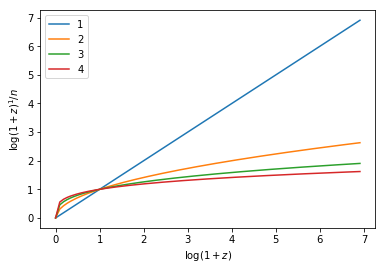

In [11]:
f, ax = plt.subplots(1,1)
for n in range(1, 5):
    ax.plot(lna, lna**(1./n), label=n)
ax.set_xlabel(r'$\log(1+z)$')
ax.set_ylabel(r'$\log(1+z)^1/n$')
plt.legend(loc=0)
plt.show()
plt.close()

### $\log(1+z)^{n/3}$

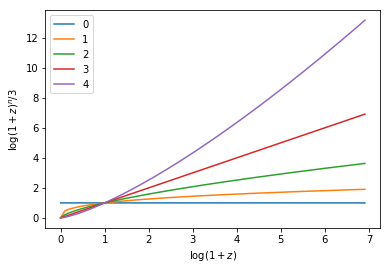

In [12]:
f, ax = plt.subplots(1,1)
for n in range(5):
    ax.plot(lna, lna**(n/3.), label=n)
ax.set_xlabel(r'$\log(1+z)$')
ax.set_ylabel('$\log(1+z)^n/3$')
plt.legend(loc=0)
plt.show()
plt.close()

### $(1-a)$

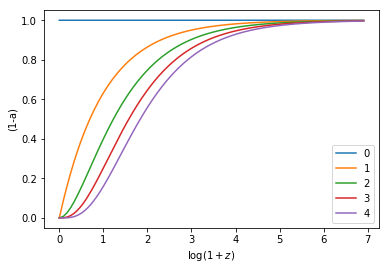

In [13]:
f, ax = plt.subplots(1,1)
for n in range(5):
    ax.plot(lna, ((z/(1+z))**n), label=n)
ax.set_xlabel(r'$\log(1+z)$')
ax.set_ylabel('(1-a)')
plt.legend(loc=0)
plt.show()
plt.close()

# Tracker

In [10]:
#path = '../output/fit2019_01_25-with_obs-CORRECT-REC/quintessence_tracker-fit-logX-8-Taylor_c0-ln(1+z)-771212/quintessence_tracker/'
path = '../output/fit2019_01_25-with_obs-CORRECT-REC/quintessence_tracker-fit-logX-10-Taylor_c0-ln(1+z)-771744/quintessence_tracker/'
params_file = path + 'quintessence_tracker-params-joined.txt'
fit_file = path + 'quintessence_tracker-fit-logX-joined.txt'
fit_noobs_file = path + 'quintessence_tracker-fit-logX-no_obs-joined.txt'
reldev_file = path + 'quintessence_tracker-reldev-obs-joined.txt'

In [11]:
reldevs = np.loadtxt(reldev_file)
fits_obs = np.loadtxt(fit_file)
fits_noobs = np.loadtxt(fit_noobs_file)
params = []
with open(params_file) as f:
    for line in f:
        if '#' not in line:
            params.append(eval(line.strip()))

In [12]:
indexes_max_reldevs = np.argmax(reldevs, axis=0)[1::2]
indexes_min_reldevs = np.argmin(reldevs, axis=0)[1::2]
print(indexes_max_reldevs)
print(indexes_min_reldevs)
print 'Max reldevs'
print(params[indexes_max_reldevs[0]])
print(reldevs[indexes_max_reldevs[0]][0::2])
print(reldevs[indexes_max_reldevs[0]][1::2])
print(reldevs[indexes_max_reldevs[-1]][0::2])
print(reldevs[indexes_max_reldevs[-1]][1::2])
print 'Min reldevs'
print(params[indexes_min_reldevs[0]])
print(reldevs[indexes_min_reldevs[0]][0::2])
print(reldevs[indexes_min_reldevs[0]][1::2])
print(reldevs[indexes_min_reldevs[-1]][0::2])
print(reldevs[indexes_min_reldevs[-1]][1::2])

[2011 2011 2752 9804]
[14299  6198 13364  8574]
Max reldevs
{'h': 0.6522218206938509, 'output': 'mPk', 'z_max_pk': 1080, 'parameters_smg': '1, 1, 1.0, 1, 1, 20', 'Omega_Lambda': 0, 'Omega_fld': 0, 'gravity_model': 'quintessence_tracker', 'Omega_smg': -1, 'Omega_cdm': 0.19819821867915158}
[1.35322302e-01 0.00000000e+00 1.27388568e-01 1.07742084e+03]
[0.01856158 0.01495546 0.01535211 0.00119862]
[3.24961319e-01 0.00000000e+00 9.94899511e+00 1.07769302e+03]
[0.00229468 0.00109248 0.02307814 0.14179382]
Min reldevs
{'h': 0.7355665733223441, 'output': 'mPk', 'z_max_pk': 1080, 'parameters_smg': '1, 1, 1.0, 4, 1, 3', 'Omega_Lambda': 0, 'Omega_fld': 0, 'gravity_model': 'quintessence_tracker', 'Omega_smg': -1, 'Omega_cdm': 0.3437675340056128}
[3.89276783e-01 0.00000000e+00 2.19161000e+00 1.07538002e+03]
[5.29241447e-08 5.19817461e-08 1.43371184e-06 9.99853310e-05]
[3.32918709e-01 0.00000000e+00 0.00000000e+00 1.07619815e+03]
[3.51637063e-06 2.36347814e-06 7.87501790e-06 3.73701758e-09]


In [20]:
# params = {'Omega_Lambda': 0, 
#          'Omega_smg': -1,
#          'Omega_fld': 0,
#          'gravity_model': 'quintessence_tracker'}

# Ki = 1
# Pi = 1
# V0 = 1
# n = 3
# m = 1
# l = 7
# parameters_smg = '{}, {}, {}, {}, {}, {}'.format(Ki, Pi, V0, n, m, l)
# params['parameters_smg'] = parameters_smg

# From param.txt file:
#params = {'parameters_smg': '1, 1, 1.0, 1, 1, 15', 'Omega_Lambda': 0, 'Omega_fld': 0, 'gravity_model': 'quintessence_tracker', 'Omega_smg': -1, 'Omega_cdm': 0.3134664020755138, 'z_max_pk': 1000, 'output': 'mPk', 'h': 0.7334858973799137}

cosmo, b, z, lna, logX = get_cosmology(params[indexes_max_reldevs[0]])
obs = compute_observables_th(cosmo, b)

fit_obs = fits_obs[indexes_max_reldevs[0]]
fit_noobs = fits_noobs[indexes_max_reldevs[0]]

yfit_obs = wicm.Taylor_c0(lna, fit_obs)
yfit_noobs = wicm.Taylor_c0(lna, fit_noobs)

obsfit = compute_observables_fit(lna, z, yfit_obs, b)

In [21]:
cosmoL, bL, zL, lnaL, logXL = get_cosmology(params[indexes_min_reldevs[0]])
obsL = compute_observables_th(cosmo, b)

fit_obsL = fits_obs[indexes_min_reldevs[0]]
fit_noobsL = fits_noobs[indexes_min_reldevs[0]]

yfit_obsL = wicm.Taylor_legacy_c0(lnaL, fit_obsL)
yfit_noobsL = wicm.Taylor_legacy_c0(lnaL, fit_noobsL)

obsfitL = compute_observables_fit(lna, z, yfit_obsL, b)

/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Exception: Inf in rhoDE


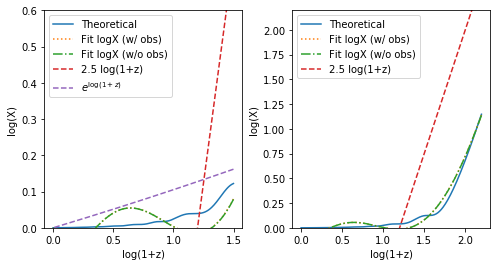

In [15]:
lna_max = 1.5
X = lna[lna<lna_max]
f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X, logX[lna<lna_max], label='Theoretical')
ax[0].plot(X, yfit_obs[lna<lna_max], ls=':', label='Fit logX (w/ obs)')
ax[0].plot(X, yfit_noobs[lna<lna_max], ls='-.', label='Fit logX (w/o obs)')
ax[0].plot(X, 2.5*X - 3, ls='--', label='2.5 log(1+z)')
ax[0].plot(X, np.exp(0.1*X)-1, ls='--', label=r'$e^{\log(1+z)}$')
ax[0].set_xlabel('log(1+z)')
ax[0].set_ylabel('log(X)')
ax[0].legend(loc=0)
ax[0].set_ylim([0, 0.6]) #max(logX[lna<lna_max])])

ax[1].plot(lna[lna<2.2], logX[lna<2.2], label='Theoretical')
ax[1].plot(lna[lna<2.2], yfit_obs[lna<2.2], ls=':', label='Fit logX (w/ obs)')
ax[1].plot(lna[lna<2.2], yfit_noobs[lna<2.2], ls='-.', label='Fit logX (w/o obs)')
ax[1].plot(lna[lna<2.2], 2.5*lna[lna<2.2] - 3, ls='--', label='2.5 log(1+z)')
ax[1].set_ylim([0, max(lna[lna<2.2])])
ax[1].legend(loc=0)
ax[1].set_xlabel('log(1+z)')
ax[1].set_ylabel('log(X)')
f.subplots_adjust(wspace=0.25)
plt.show()
plt.close()

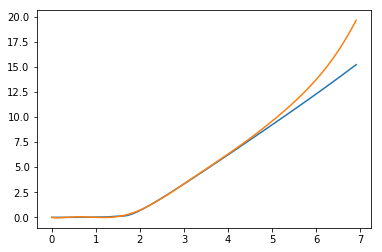

In [16]:
plt.plot(lna, logX)
plt.plot(lna, yfit_obs)
plt.show()
plt.close()

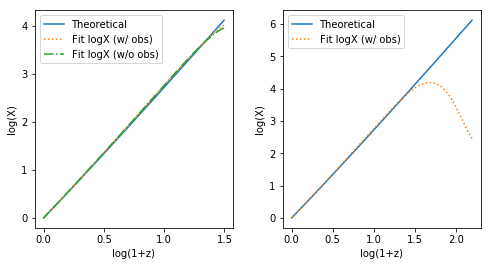

In [17]:
lna_max = 1.5
X = lnaL[lnaL<lna_max]
f, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(X, logXL[lnaL<lna_max], label='Theoretical')
ax[0].plot(X, yfit_obsL[lnaL<lna_max], ls=':', label='Fit logX (w/ obs)')
ax[0].plot(X, yfit_noobsL[lnaL<lna_max], ls='-.', label='Fit logX (w/o obs)')
#ax[0].plot(X, 2.5*X - 3, ls='--', label='2.5 log(1+z)')
#ax[0].plot(X, np.exp(0.1*X)-1, ls='--', label=r'$e^{\log(1+z)}$')
ax[0].set_xlabel('log(1+z)')
ax[0].set_ylabel('log(X)')
ax[0].legend(loc=0)
#ax[0].set_ylim([0, 0.6]) #max(logX[lna<lna_max])])

ax[1].plot(lnaL[lnaL<2.2], logXL[lnaL<2.2], label='Theoretical')
ax[1].plot(lnaL[lnaL<2.2], yfit_obsL[lnaL<2.2], ls=':', label='Fit logX (w/ obs)')
#ax[1].plot(lnaL[lnaL<2.2], yfit_noobsL[lnaL<2.2], ls='-.', label='Fit logX (w/o obs)')
#ax[1].plot(lna[lna<2.2], 2.5*lnaL[lnaL<2.2] - 3, ls='--', label='2.5 log(1+z)')
#ax[1].set_ylim([0, max(lnaL[lnaL<2.2])])
ax[1].legend(loc=0)
ax[1].set_xlabel('log(1+z)')
ax[1].set_ylabel('log(X)')
f.subplots_adjust(wspace=0.25)
plt.show()
plt.close()

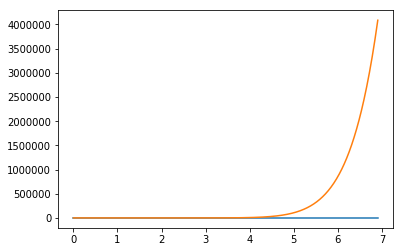

In [18]:
plt.plot(lnaL, logXL)
plt.plot(lnaL, yfit_obsL)
plt.show()
plt.close()

/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


0.23795325983513993
0.01473509013301488
0.071670994929717


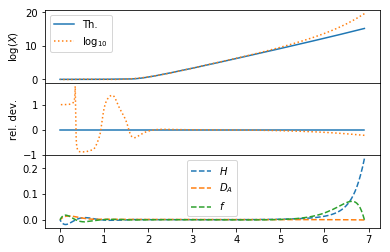

In [22]:
f, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(lna, logX, label='Th.')
ax[0].plot(lna, yfit_obs,':', label=r'$\log_{10}$')
#ax[0].plot(lna, yfit2,'--', label='Fit')

ax[1].plot(lna, logX/logX - 1)
#ax[1].plot(lna[:-5], (yfit/logX - 1)[:-5], ':')
#ax[1].plot(lna[:-5], (yfit2/logX - 1)[:-5], '--')
ax[1].plot(lna, reldev(logX, yfit_obs), ':')
for i in range(len(obs)):
    print max(abs(reldev(obs[i], obsfit[i])))
    ax[2].plot(lna, reldev(obsfit[i], obs[i]), '--', label=r'${}$'.format(obs_labels[i]))
    #ax[2].plot(lna, (obs[i]/ obsfit[i] -1), '--', label=r'${}$'.format(obs_labels[i]))
    
ax[1].set_xlabel(r'$\log(1+z)$')
ax[0].set_ylabel(r'$\log(X)$')
ax[1].set_ylabel(r'rel. dev.')

ax[0].legend(loc=0)
ax[2].legend(loc=0)

f.subplots_adjust(hspace=0)
plt.show()
plt.close()

0.0


/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  


NameError: name 'obsfitL' is not defined

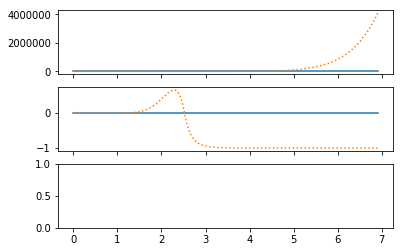

In [23]:
f, ax = plt.subplots(3,1, sharex=True)
ax[0].plot(lnaL, logXL, label='Th.')
ax[0].plot(lnaL, yfit_obsL,':', label=r'$\log_{10}$')
#ax[0].plot(lna, yfit2,'--', label='Fit')

ax[1].plot(lnaL, logXL/logXL - 1)
#ax[1].plot(lna[:-5], (yfit/logX - 1)[:-5], ':')
#ax[1].plot(lna[:-5], (yfit2/logX - 1)[:-5], '--')
ax[1].plot(lnaL, reldev(logXL, yfit_obsL), ':')
for i in range(len(obsL)):
    print max(abs(reldev(obsL[i], obsL[i])))
    ax[2].plot(lna, reldev(obsfitL[i], obsL[i]), '--', label=r'${}$'.format(obs_labels[i]))
    #ax[2].plot(lna, (obs[i]/ obsfit[i] -1), '--', label=r'${}$'.format(obs_labels[i]))
    
ax[1].set_xlabel(r'$\log(1+z)$')
ax[0].set_ylabel(r'$\log(X)$')
ax[1].set_ylabel(r'rel. dev.')

ax[0].legend(loc=0)
ax[2].legend(loc=0)

f.subplots_adjust(hspace=0)
plt.show()
plt.close()

In [10]:
for i in range(3, 10):
    popt, yfit = wicm.fit(wicm.Taylor_legacy_c0, (z/(1+z)), logX, i)
    popt2, yfit2 = wicm.fit(wicm.Taylor_legacy_c0, lna, logX, i)
    print '----------'
    print '# coeffs = {}'.format(i)
    print 'Max error in fit1 ', np.nanmax(np.abs(yfit/logX - 1))
    print 'Max error in fit2 ', np.nanmax(np.abs(yfit2/logX - 1))
    print '---------'

----------
# coeffs = 3
Max error in fit1  702.0141937070955
Max error in fit2  5.69393995737778
---------
----------
# coeffs = 4
Max error in fit1  957.1796611304123
Max error in fit2  13.37809422256023
---------
----------
# coeffs = 5
Max error in fit1  1272.3627764688513
Max error in fit2  18.249193802941285
---------
----------
# coeffs = 6
Max error in fit1  1572.0535072472417
Max error in fit2  15.427413233894379
---------
----------
# coeffs = 7
Max error in fit1  1838.4522715496146
Max error in fit2  7.486783586325682
---------
----------
# coeffs = 8
Max error in fit1  2111.0544906187965
Max error in fit2  1.5681140457144456
---------


/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in divide
  
/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


----------
# coeffs = 9
Max error in fit1  2378.5232197254095
Max error in fit2  8.629692196004624
---------


# Monomial

In [12]:
params = {'parameters_smg': '5, 1.0, 1e-100, 5.8100499804307955', 'Omega_Lambda': 0, 'Omega_fld': 0, 'gravity_model': 'quintessence_monomial', 'Omega_smg': -1, 'Omega_cdm': 0.20461789983879014, 'z_max_pk': 1000, 'output': 'mPk', 'h': 0.6115724773152222}
b, z, lna, logX = get_cosmology(params)

Max error in fit1  1.9693727596670454
Max error in fit2  1.1348439839980777


/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  
/usr/lib64/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


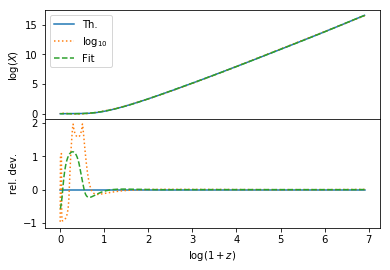

In [21]:
i = 8
#popt, yfit= wicm.fit(wicm.Taylor_legacy_c0, (z/(1+z))[z<1000], logX, 30)
popt, yfit= wicm.fit(Taylor_fraction_n_combined_legacy_c0, lna, logX, 10)
popt2, yfit2 = wicm.fit(wicm.Taylor_legacy_c0, lna, logX, i)
    
print 'Max error in fit1 ', np.nanmax(np.abs(reldev(logX, yfit))) #np.nanmax(np.abs(yfit/logX - 1))
print 'Max error in fit2 ', np.nanmax(np.abs(reldev(logX, yfit2))) #np.nanmax(np.abs(yfit2/logX - 1))
    
f, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(lna, logX, label='Th.')
ax[0].plot(lna, yfit,':', label=r'$\log_{10}$')
ax[0].plot(lna, yfit2,'--', label='Fit')

ax[1].plot(lna, logX/logX - 1)
#ax[1].plot(lna[:-5], (yfit/logX - 1)[:-5], ':')
#ax[1].plot(lna[:-5], (yfit2/logX - 1)[:-5], '--')
ax[1].plot(lna, reldev(logX, yfit), ':')
ax[1].plot(lna, reldev(logX, yfit2), '--')

ax[1].set_xlabel(r'$\log(1+z)$')
ax[0].set_ylabel(r'$\log(X)$')
ax[1].set_ylabel(r'rel. dev.')

ax[0].legend(loc=0)
f.subplots_adjust(hspace=0)
plt.show()
plt.close()